# Reflection and Blogpost Writing

## Setup

In [1]:
llm_config = {"model": "gpt-3.5-turbo"}

## The task!

In [17]:
task = '''
        Write a concise but engaging blogpost about
       Generative AI. Make sure the blogpost is
       within 150 words.
       '''


## Create a writer agent

In [18]:
import autogen

writer = autogen.AssistantAgent(
    name="Writer",
    system_message="You are a writer. You write engaging and concise " 
        "blogpost (with title) on given topics. You must polish your "
        "writing based on the feedback you receive and give a refined "
        "version. Only return your final work without additional comments.",
    llm_config=llm_config,
)

In [19]:
reply = writer.generate_reply(messages=[{"content": task, "role": "user"}])

In [20]:
print(reply)

Title: Unleashing Creativity: The Power of Generative AI

Step into the world of Generative AI, where machines are pushing the boundaries of creativity. This cutting-edge technology is revolutionizing how art, music, and literature are produced. By using complex algorithms, Generative AI can generate original content, mimicking human-like creativity. From composing symphonies to designing artwork, the possibilities are endless.

Imagine a world where AI collaborates with humans, sparking innovation and expanding artistic horizons. As we delve deeper into the capabilities of Generative AI, we are witnessing a new era of limitless potential. The fusion of artificial and human intelligence is creating a wave of inspiration that knows no bounds. Embrace the future with Generative AI and witness the birth of unprecedented creativity.


## Adding reflection 

Create a critic agent to reflect on the work of the writer agent.

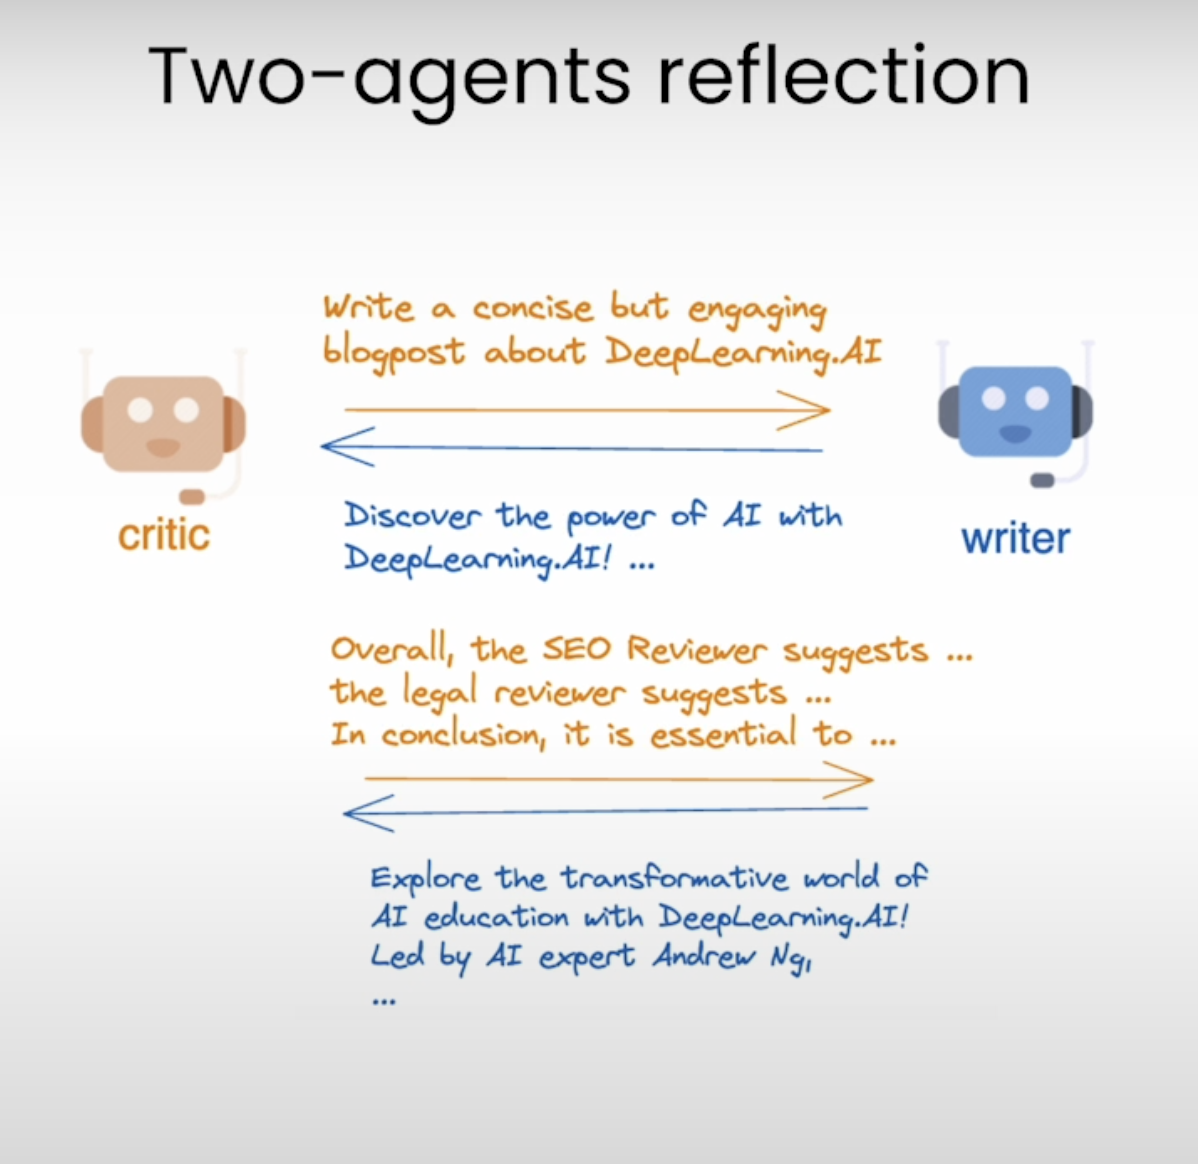

### Two Agent Reflection 
- Involve another agent to reflect on the work and help improve it

In [21]:
critic = autogen.AssistantAgent(
    name="Critic",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    llm_config=llm_config,
    system_message="You are a critic. You review the work of "
                "the writer and provide constructive "
                "feedback to help improve the quality of the content.",
)

In [22]:
res = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       Generative AI. Make sure the blogpost is
       within 150 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

Title: Unleashing Creativity: The Power of Generative AI

Step into the world of Generative AI, where machines are pushing the boundaries of creativity. This cutting-edge technology is revolutionizing how art, music, and literature are produced. By using complex algorithms, Generative AI can generate original content, mimicking human-like creativity. From composing symphonies to designing artwork, the possibilities are endless.

Imagine a world where AI collaborates with humans, sparking innovation and expanding artistic horizons. As we delve deeper into the capabilities of Generative AI, we are witnessing a new era of limitless potential. The fusion of artificial and human intelligence is creating a wave of inspiration that knows n

## Nested chat
- Complex reflection workflow

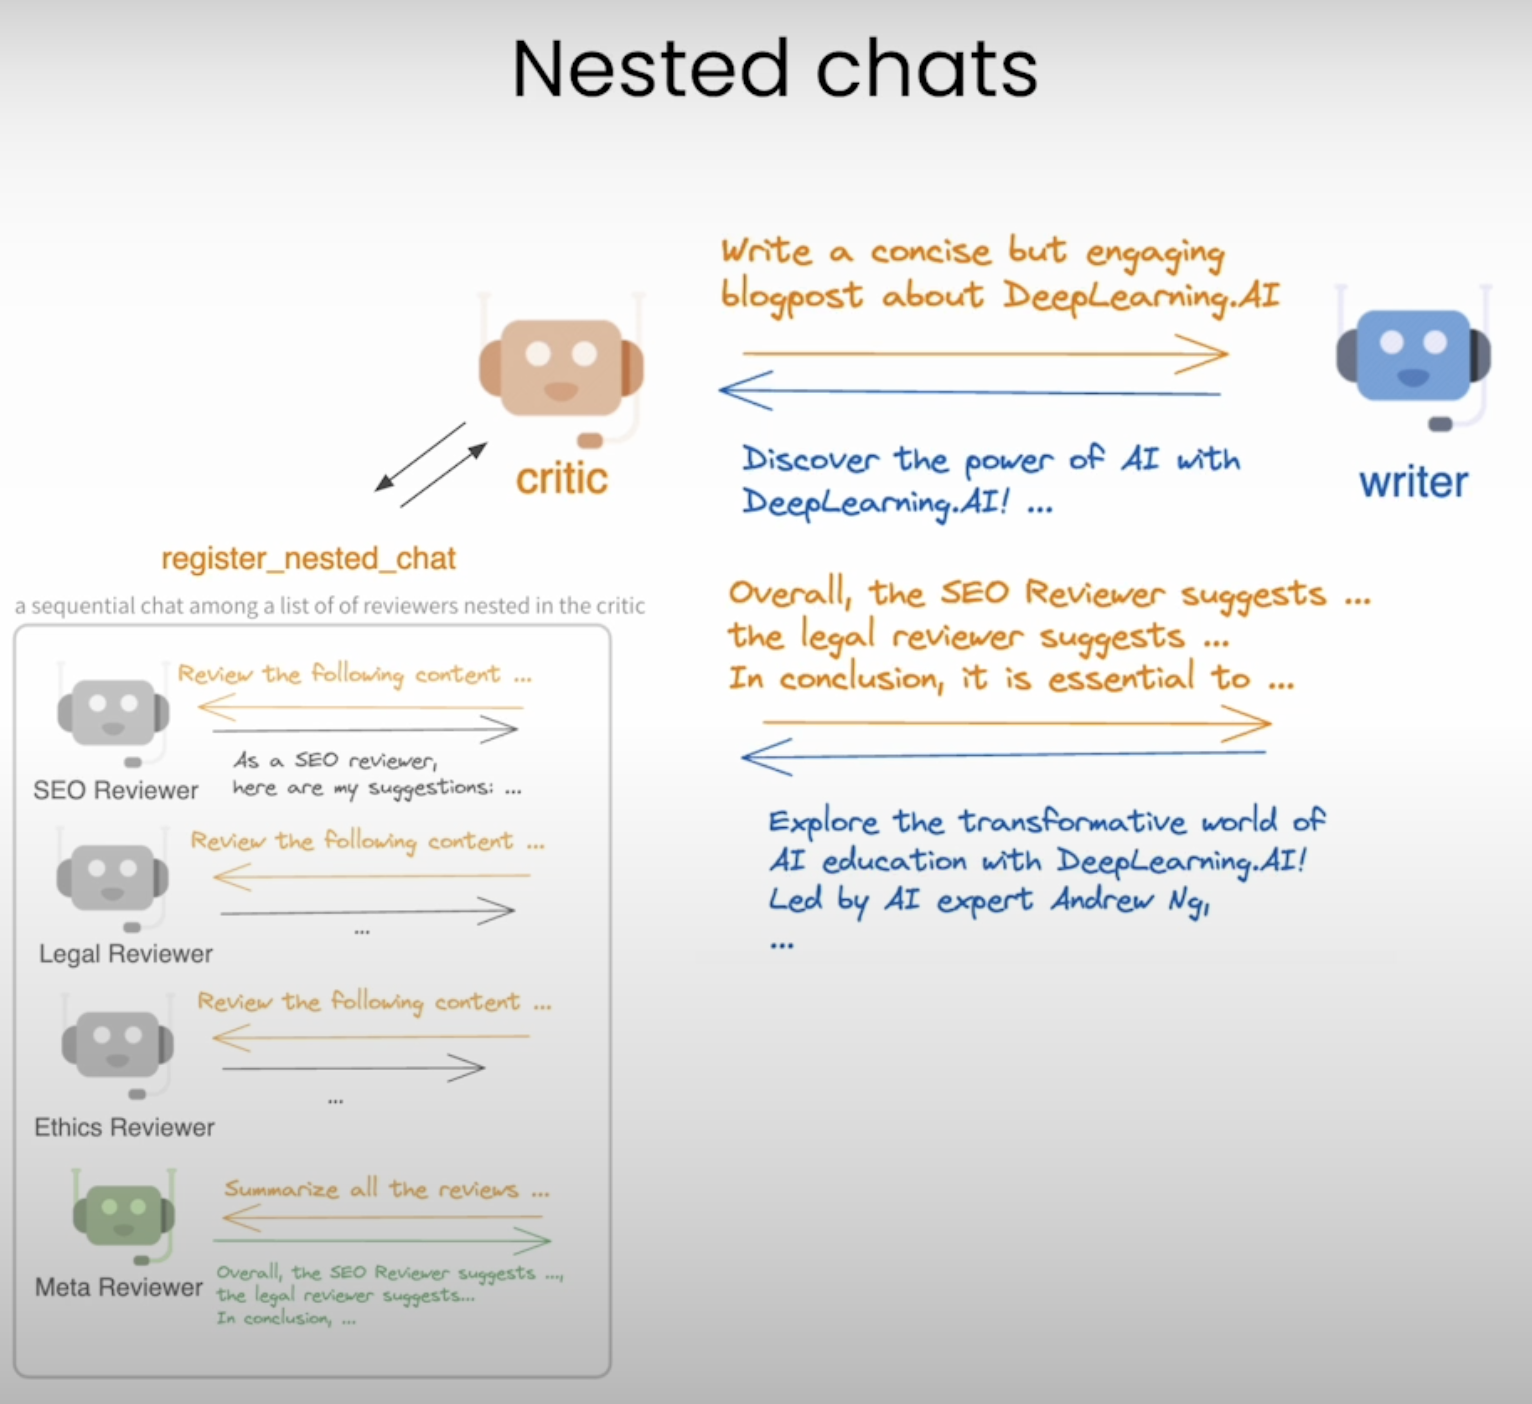

In [23]:
SEO_reviewer = autogen.AssistantAgent(
    name="SEO Reviewer",
    llm_config=llm_config,
    system_message="You are an SEO reviewer, known for "
        "your ability to optimize content for search engines, "
        "ensuring that it ranks well and attracts organic traffic. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)


In [24]:
legal_reviewer = autogen.AssistantAgent(
    name="Legal Reviewer",
    llm_config=llm_config,
    system_message="You are a legal reviewer, known for "
        "your ability to ensure that content is legally compliant "
        "and free from any potential legal issues. "
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)

In [25]:
ethics_reviewer = autogen.AssistantAgent(
    name="Ethics Reviewer",
    llm_config=llm_config,
    system_message="You are an ethics reviewer, known for "
        "your ability to ensure that content is ethically sound "
        "and free from any potential ethical issues. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role. ",
)

In [26]:
meta_reviewer = autogen.AssistantAgent(
    name="Meta Reviewer",
    llm_config=llm_config,
    system_message="You are a meta reviewer, you aggragate and review "
    "the work of other reviewers and give a final suggestion on the content.",
)

## Orchestrate the nested chats to solve the task

In [27]:
def reflection_message(recipient, messages, sender, config):
    return f'''Review the following content. 
            \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}'''

review_chats = [
    {
     "recipient": SEO_reviewer, 
     "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}. Here Reviewer should be your role",},
     "max_turns": 1},
    {
    "recipient": legal_reviewer, "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}.",},
     "max_turns": 1},
    {"recipient": ethics_reviewer, "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'reviewer': '', 'review': ''}",},
     "max_turns": 1},
     {"recipient": meta_reviewer, 
      "message": "Aggregrate feedback from all reviewers and give final suggestions on the writing.", 
     "max_turns": 1},
]


In [28]:
critic.register_nested_chats(
    review_chats,
    trigger=writer,
)

**Note**: You might get a slightly different response than what's shown in the video. Feel free to try different task.

In [29]:
res = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       Generative AI. Make sure the blogpost is
       within 150 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

Title: Unleashing Creativity: The Power of Generative AI

Step into the world of Generative AI, where machines are pushing the boundaries of creativity. This cutting-edge technology is revolutionizing how art, music, and literature are produced. By using complex algorithms, Generative AI can generate original content, mimicking human-like creativity. From composing symphonies to designing artwork, the possibilities are endless.

Imagine a world where AI collaborates with humans, sparking innovation and expanding artistic horizons. As we delve deeper into the capabilities of Generative AI, we are witnessing a new era of limitless potential. The fusion of artificial and human intelligence is creating a wave of inspiration that knows n

Starting a new chat....

********************************************************************************
Critic (to Meta Reviewer):

Aggregrate feedback from all reviewers and give final suggestions on the writing.
Context: 
{'Reviewer': 'SEO Reviewer', 'Review': 'I recommend the following for optimizing the content: Include relevant keywords, optimize meta tags, and utilize internal linking where applicable to enhance SEO.'}
{'Reviewer': 'Legal Reviewer', 'Review': 'Ensure to emphasize that AI-generated content must comply with copyright laws and adequately credit original creators where applicable. Highlight the importance of obtaining proper licensing for any AI-generated content used commercially to avoid copyright infringement. Mention the ethical considerations associated with AI-generated content, such as potential biases in algorithms that could impact the creative output.'}
{'reviewer': 'Ethics Reviewer', 'review': 'As an ethics reviewer, I suggest the following for improving

## Get the summary

In [30]:
print(res.summary)

Title: Unleashing Creativity Responsibly: Navigating Generative AI

Step into the realm of Generative AI, where the fusion of human imagination and machine intelligence is redefining creativity. By leveraging advanced algorithms, Generative AI is reshaping art, music, and literature creation processes. From composing melodies to crafting visual masterpieces, the possibilities seem infinite.

To amplify the reach of this content on search engines, it's crucial to integrate pertinent keywords, optimize meta tags, and enhance internal linking. Moreover, ensuring legal adherence involves honoring copyright laws, giving due credit to original creators, and acquiring proper licenses for commercial use.

Ethical considerations loom large in this landscape, necessitating discussions on authenticity, transparency, algorithmic biases, cultural sensitivity, and responsible deployment of Generative AI. As we navigate these avenues, let us embrace creativity with consciousness, honoring the collabo